### Calculate tcw on daily images

In [1]:
tile = '0 -13'

In [2]:
# Check and reset path
!pwd

/home/jovyan/dev/dea-notebooks/Gabrielle_dev/LCCS_wet_veg


In [3]:
# Import modules
import datacube
import pandas as pd
import matplotlib.pyplot as plt
import sys
import xarray as xr
from os import path
from datacube.helpers import write_geotiff
from datacube.virtual import catalog_from_file
import numpy as np
from itertools import groupby

sys.path.append("../Scripts")
from dea_datahandling import load_ard
from dea_bandindices import calculate_indices

dc = datacube.Datacube(app='Load tiles')

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


In [4]:
# Define funciton to get tile bounds
def get_tile_bounds(tile):
    x, y = tile.split(' ')
    minx = int(x) * 100000
    miny = int(y) * 100000
    maxx = minx + 100000
    maxy = miny + 100000

    return {'minx': minx, 'miny': miny, 'maxx': maxx, 'maxy': maxy}

In [5]:
bounds = get_tile_bounds(tile)
print('Bounds',bounds)

Bounds {'minx': 0, 'miny': -1300000, 'maxx': 100000, 'maxy': -1200000}


In [6]:
# Load the imagery
# service = '/home/jovyan/development/'

x=(bounds['minx'],bounds['maxx'])
y=(bounds['miny'],bounds['maxy'])
res = (-100, 100)
crs = "EPSG:3577"
time = ("2015-01-01", "2015-03-30")
output_crs = "EPSG:3577"
measurements = ['nbart_blue','nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']

query =({'time': time,
     'x':x,
     'y':y,
     'crs':crs,
     'output_crs':output_crs,
     'resolution':res,
     'measurements':measurements,
     'group_by':'solar_day'})
# catalog = catalog_from_file(str(service)+'livingearth_australia/le_plugins/virtual_product_cat.yaml')
# product = catalog['daily_ard']
    
ds = load_ard(dc=dc,products=['ga_ls8c_ard_3'], **query)


Loading ga_ls8c_ard_3 data
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Combining and sorting data
    Returning 11 observations 


In [7]:
print('collection:', ds)

collection: <xarray.Dataset>
Dimensions:       (time: 11, x: 1000, y: 1000)
Coordinates:
    spatial_ref   int32 3577
  * y             (y) float64 -1.2e+06 -1.2e+06 -1.2e+06 ... -1.3e+06 -1.3e+06
  * x             (x) float64 50.0 150.0 250.0 ... 9.975e+04 9.985e+04 9.995e+04
  * time          (time) datetime64[ns] 2015-01-05T01:10:28.929108 ... 2015-03-26T01:09:56.920629
Data variables:
    nbart_blue    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_green   (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_red     (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_nir     (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_swir_1  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_swir_2  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


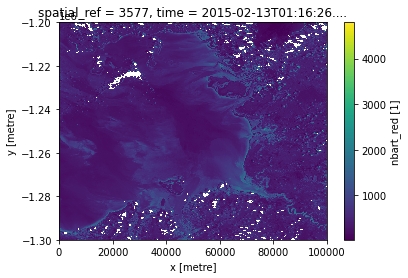

In [8]:
ds.isel(time=5).nbart_red.plot()

# The process

In [9]:
def consecutive_count(water_numpy, consecutive_numpy, required_consecutive, consec_msk_val=1):
    '''
    function to get consective count of water (1) for each pixel across the time series

    :param numpy.array water_numpy: 3-D array of tv[z,y,x]
    :param numpy.array consecutive_numpy: bool output array for water (1) and not water (0)
    :param float required_consecutive: how many consectutive 1's to be classified as water?
    :param float consec_msk_val: what value to calculcate consectutives on
           default is water (1)     
    '''

    for y in range(water_numpy.shape[1]):
        for x in range(water_numpy.shape[2]):
            # If all the values are nan then just set output to nan and carry on
            pixel = water_numpy[:,y,x]

            if np.all(np.isnan(pixel)):
                consecutive_numpy[y,x] = np.nan
                continue            

            # Get counts of consecutive water classifications
            counts = [len(list(group)) for label, group in groupby(pixel[(~np.isnan(pixel))]) if label == 1]

            if not counts:
                consecutive_numpy[y,x] = 0
            elif max(counts) >= required_consecutive:
                consecutive_numpy[y,x] = 1
            else:
                consecutive_numpy[y,x] = 0

    return consecutive_numpy

In [10]:
# Calculate tcw 
tcw = calculate_indices(ds,
                        index='TCW', 
                        collection='ga_ls_3',
                        drop=False,
                        normalise=False)
print('tcw',tcw)

../Scripts/dea_bandindices.py:268: UserWarning: 
A coefficient-based index ('TCW') normally applied to surface reflectance values in the 
0.0-1.0 range was applied to values in the 0-10000 range. This can produce unexpected results; 
if required, resolve this by setting `normalise=True`
  warnings.warn(f"\nA coefficient-based index ('{index}') normally "


tcw <xarray.Dataset>
Dimensions:       (time: 11, x: 1000, y: 1000)
Coordinates:
    spatial_ref   int32 3577
  * y             (y) float64 -1.2e+06 -1.2e+06 -1.2e+06 ... -1.3e+06 -1.3e+06
  * x             (x) float64 50.0 150.0 250.0 ... 9.975e+04 9.985e+04 9.995e+04
  * time          (time) datetime64[ns] 2015-01-05T01:10:28.929108 ... 2015-03-26T01:09:56.920629
Data variables:
    nbart_blue    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_green   (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_red     (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_nir     (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_swir_1  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_swir_2  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    TCW           (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spa

In [11]:
# Select clear and water pixels - binary
wet = (tcw.TCW > -600).to_dataset()
print('wet',wet)

wet <xarray.Dataset>
Dimensions:      (time: 11, x: 1000, y: 1000)
Coordinates:
    spatial_ref  int32 3577
  * y            (y) float64 -1.2e+06 -1.2e+06 -1.2e+06 ... -1.3e+06 -1.3e+06
  * x            (x) float64 50.0 150.0 250.0 ... 9.975e+04 9.985e+04 9.995e+04
  * time         (time) datetime64[ns] 2015-01-05T01:10:28.929108 ... 2015-03-26T01:09:56.920629
Data variables:
    TCW          (time, y, x) bool False False False False ... False False False


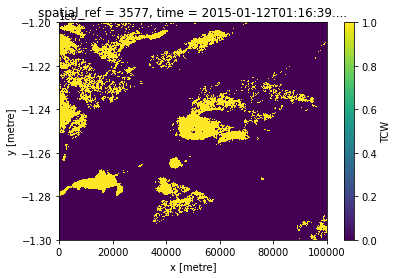

In [12]:
wet.isel(time=1).TCW.plot()

In [13]:
# Group by month - total number of observations
wet_month = wet.groupby('time.month').sum(dim='time')  
print('wet_month',wet_month)

wet_month <xarray.Dataset>
Dimensions:      (month: 3, x: 1000, y: 1000)
Coordinates:
    spatial_ref  int32 3577
  * y            (y) float64 -1.2e+06 -1.2e+06 -1.2e+06 ... -1.3e+06 -1.3e+06
  * x            (x) float64 50.0 150.0 250.0 ... 9.975e+04 9.985e+04 9.995e+04
  * month        (month) int64 1 2 3
Data variables:
    TCW          (month, y, x) int64 1 1 1 0 0 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0


In [14]:
# Now if at least one time was observed as wet make it 1 (end result in binary wet mask)
wet_once = wet_month.TCW >= 1
print('wet_once',wet_once)

wet_once <xarray.DataArray 'TCW' (month: 3, y: 1000, x: 1000)>
array([[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],

       [[ True,  True,  True, ...,  True, False, False],
        [ True,  True,  True, ..., False, False,  True],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],

       [[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., Fals

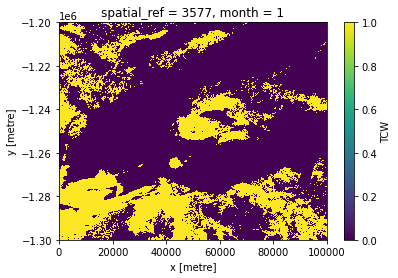

In [15]:
wet_once.isel(month=0).plot()

In [16]:
# Pull tv as numpy array
wet_numpy = wet_once.values
print('wet_numpy',wet_numpy.shape)

wet_numpy (3, 1000, 1000)


In [17]:
# executing consecutive_count function #
# consecutive months
required_consecutive = 1

In [18]:
# Set up array for output (faster to pre-allocate for numba).
# Needs to be float32 for NaN
consecutive_numpy = np.empty((wet_numpy.shape[1], wet_numpy.shape[2]), dtype=np.float32)

In [19]:
# Run function to get array of with 1 where number of consecutive values for different
# dates is >= required_consecutive
consecutive_numpy = consecutive_count(wet_numpy, consecutive_numpy, required_consecutive)

In [20]:
# reduce original array to 2D
# using max here but not important as we just want to use shape/attributes
wet_reduce = wet_month.max(dim='month')

In [21]:
# create new data array with sampe dimensions as original
wet_summary = xr.DataArray(consecutive_numpy, coords=wet_reduce.coords, dims=wet_reduce.dims)  
wet_summary.to_dataset(name='waterper_wat_cin')

<xarray.Dataset>
Dimensions:           (x: 1000, y: 1000)
Coordinates:
    spatial_ref       int32 3577
  * y                 (y) float64 -1.2e+06 -1.2e+06 ... -1.3e+06 -1.3e+06
  * x                 (x) float64 50.0 150.0 250.0 ... 9.985e+04 9.995e+04
Data variables:
    waterper_wat_cin  (x, y) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0

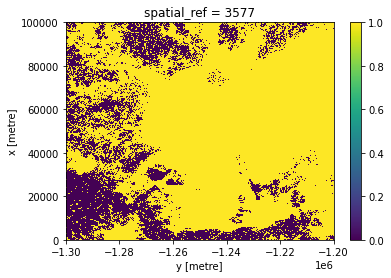

In [22]:
wet_summary.plot()

### Calaculate seasonality 
wet_once is the binary location of water for each month


In [23]:
wet_once

<xarray.DataArray 'TCW' (month: 3, y: 1000, x: 1000)>
array([[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],

       [[ True,  True,  True, ...,  True, False, False],
        [ True,  True,  True, ..., False, False,  True],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],

       [[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]]])
Coordinates:
    spatial_ref  int32 3577
  * y            (y) float64 -1.2e+06 -1.2e+06 -1.2e+06 ... -1.3e+06 -1.3e+06
  * x            (x) float64 50.0 150.0 250.0 ... 9.975e+04 9.985e+04 9.995e+04
  * month        (month) int64 1 2 3

In [24]:
watersea = wet_once

In [25]:
watersea.values = np.zeros_like(wet_once, dtype='float64')

In [26]:
# using wofs_annual_summary to seperate Water < 3 months (<= 0.25) and Water > 3 months (> 0.25)
watersea.values = np.where(((watersea > 0) & (watersea <= 3)), 2, watersea.values)
watersea.values = np.where(((watersea > 3) & (watersea <= 12)), 1, watersea.values)

In [27]:
watersea.to_dataset(name='watersea_veg_cat').squeeze().drop('month')

<xarray.Dataset>
Dimensions:           (month: 3, x: 1000, y: 1000)
Coordinates:
    spatial_ref       int32 3577
  * y                 (y) float64 -1.2e+06 -1.2e+06 ... -1.3e+06 -1.3e+06
  * x                 (x) float64 50.0 150.0 250.0 ... 9.985e+04 9.995e+04
Dimensions without coordinates: month
Data variables:
    watersea_veg_cat  (month, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [28]:


# # Calculate frequency of water observations within the month
# freq = water_month/clear_month

# # Threshold frequency in month to get water or not
# # Values greater than 0.5 kept
# water_dominant = freq['water'] > 0.5
# # Converted to binary
# water_mask = water_dominant.where(freq['water'] >= 0)

# # Make values of > 0.5 == 1 (end result in binary water mask)
# water_mask_drop = np.where(water_mask > 0.5, 1, water_mask)
# water_mask_xr = xr.DataArray(water_mask_drop, coords=water_mask.coords, dims=water_mask.dims)

# Pull tv as numpy array
water_numpy = water_mask_xr.values

# executing consecutive_count function #
# veg = 2 consecutive months
required_consecutive = 1

# Set up array for output (faster to pre-allocate for numba).
# Needs to be float32 for NaN
consecutive_numpy = np.empty((water_numpy.shape[1], water_numpy.shape[2]), dtype=np.float32)

# Run function to get array of with 1 where number of consecutive values for different
# dates is >= required_consecutive
consecutive_numpy = self.consecutive_count(water_numpy, consecutive_numpy, required_consecutive)

# reduce original array to 2D
# using max here but not important as we just want to use shape/attributes
water_reduce = water_mask.max(dim='month')

# create new data array with sampe dimensions as original
water_summary = xr.DataArray(consecutive_numpy, coords=water_reduce.coords, dims=water_reduce.dims)  
return water_summary.to_dataset(name='waterper_wat_cin')


NameError: name 'water_mask_xr' is not defined

In [32]:
from datacube.utils import cog

cog.write_cog(you_xr_dataarray,'filename.tif')

PosixPath('filename.tif')

In [33]:
pwd

'/home/jovyan/dev/dea-notebooks/Gabrielle_dev/LCCS_wet_veg'

In [29]:
# Save the tile 
dataset = test_si5.isel(time=0).to_dataset(name='si5').assign_attrs({'crs': 'EPSG:3577'})
print('Saving',base_path + out_name)
print('Saving dataset',dataset)
write_geotiff(base_path + out_name, dataset)

NameError: name 'test_si5' is not defined